<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = r'~\Documents\IOD-testing\DATA\titanic_train.csv'
titanic= pd.read_csv(titanic_csv)

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [4]:
titanic.shape

(891, 12)

In [5]:
# ANSWER
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [7]:
# Featurs to predict Survived 

X= ['Fare','Pclass','Embarked','Sex']

C:\Users\nhivo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='count'>

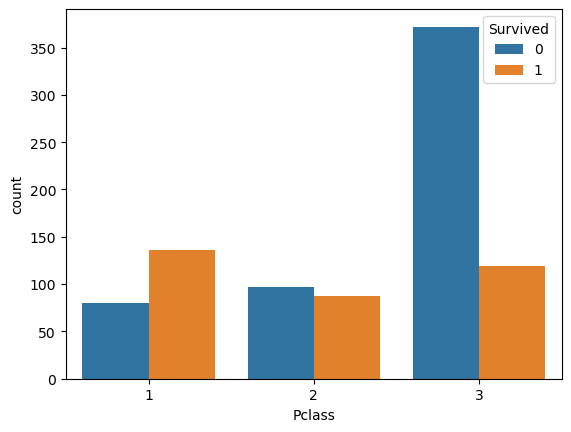

In [17]:
sns.countplot('Pclass',data=titanic,hue='Survived')

C:\Users\nhivo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sex', ylabel='count'>

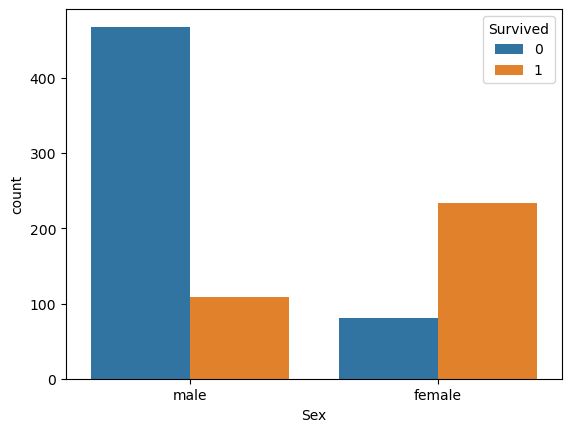

In [18]:
sns.countplot('Sex',data=titanic,hue='Survived')

C:\Users\nhivo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

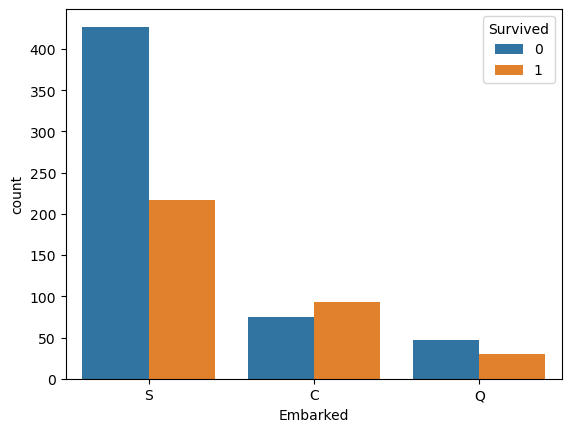

In [20]:
sns.countplot('Embarked',data=titanic,hue='Survived')

In [21]:
# Fill missing Age values by sex groups

titanic['Age'].fillna(titanic.groupby('Sex')['Age'].agg('mean'),inplace=True)

In [22]:
# fill missing Embarked values 

titanic['Embarked'].fillna('S', inplace=True)

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [9]:
# ANSWER
X=titanic[['Pclass','Parch']]
y=titanic['Survived']


#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [10]:
# ANSWER
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [11]:
# ANSWER
# Create Model

lg=LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [12]:
# ANSWER
# Fit Model
lg.fit(X,y)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [13]:
# ANSWER
lg.coef_

array([[-0.85544768,  0.24209572]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [14]:
# ANSWER
lg.intercept_

array([1.36250842])

We can create tuples of the predictor names and coefficients like this:

In [23]:
# ANSWER

feature_cols=['Pclass','Embarked']
print(set(zip(feature_cols, lg.coef_[0])))

{('Embarked', 0.2420957239322201), ('Pclass', -0.8554476812047094)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [24]:
for col in zip(X_train.columns, lg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.855448
Parch       +0.242096


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [25]:
# ANSWEr
lg.score(X_train,y_train)

0.6966292134831461

What is the  `accuracy_score` for the test data?

In [26]:
# ANSWER
lg.score(X_test,y_test)

0.6536312849162011

What can we say about this result?

ANSWER
- The model accuracy of training data is higher than of testing data
- The running model could be overfitted 

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [27]:
# ANSWER
X_age=titanic[['Pclass','Parch','Age']]
X_age['Age'].fillna(X_age['Age'].agg('mean'),inplace=True)

X_train,X_test,y_train,y_test=train_test_split(X_age,y,test_size=0.2,random_state=1)


C:\Users\nhivo\AppData\Local\Temp\ipykernel_12340\1371453025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_age['Age'].fillna(X_age['Age'].agg('mean'),inplace=True)


In [28]:
# Build Model

lg_1=LogisticRegression()
# Fit Model

lg_1.fit(X_train,y_train)
# Score




print('Train data score: ' , lg_1.score(X_train,y_train))
print('Test data score: ' , lg_1.score(X_test, y_test))

Train data score:  0.7247191011235955
Test data score:  0.664804469273743


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [29]:
# ANSWER

from sklearn import metrics

lg.fit(X_test,y_test)
y_pred_class = lg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[87 19]
 [44 29]]


Nb. Here is how `confusion_matrix` arranges its output:

In [30]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

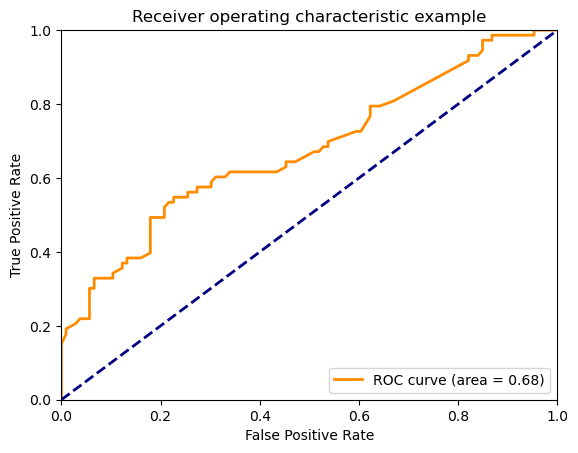

In [31]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [32]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [33]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2","Pclass_3"]].groupby(by=["Parch", "Sex_male", "Pclass_1", "Pclass_2","Pclass_3"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [34]:
# ANSWER
# Set Feature Both Numerical, Categorical

X_train,X_test,y_train,y_test=train_test_split(titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2","Pclass_3"]],titanic_with_dummies['Survived'],test_size=0.2,random_state=1)

# Build model

lg_2=LogisticRegression()

# Fit model
lg_2.fit(X_train,y_train)

LogisticRegression()

Plot the ROC curve for the new model:

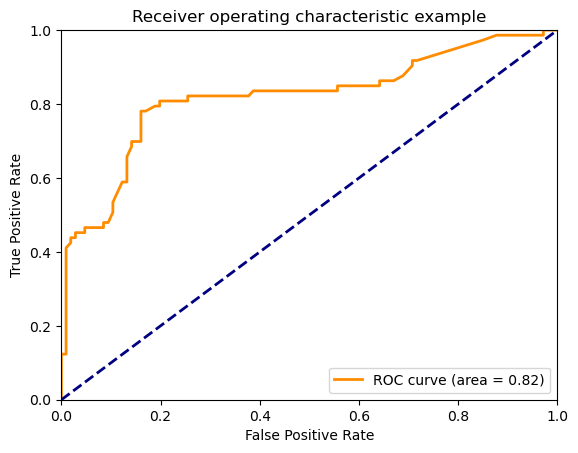

In [35]:
# ANSWER

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lg_2.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [38]:
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

    # Build Model
    logreg = LogisticRegression()

    # Fit
    logreg.fit(X_train, y_train)

    # Score
    logreg_score = logreg.score(X_test, y_test)

    # Predict
    logreg_preds = logreg.predict(X_test)

    # Predict probability

    logreg_pred_proba = logreg.predict_proba(X_test)[:,1]

    # Return accuracy rate
    return logreg_score, logreg_preds, logreg_pred_proba

In [43]:
# ANSWER

target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
score=get_logreg_score(titanic_with_dummies, feature_cols, target_col)[0]
print('Model accuracy: ', score)

Model accuracy:  0.8116591928251121


C:\Users\nhivo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                            100 * ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(), 
                                            100 * ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
                                            100 * ttwd[ttwd.Age < 16].Survived.mean(), len(ttwd[ttwd.Age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 51.96% of 102


## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

### 2. Use cross_validation 

In [47]:
 
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

C:\Users\nhivo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nhivo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.8013621241604418

### 3. Look at the fpr & tpr vectors for the best model.

In [ ]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [49]:
# Model accuracy

print(metrics.accuracy_score(y_test, y_pred_class))

0.6480446927374302


In [50]:
# Classification error

print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.35195530726256985


In [51]:
# Recall score

print(metrics.recall_score(y_test, y_pred_class))

0.3972602739726027


In [52]:
# Precision score

print(metrics.precision_score(y_test, y_pred_class))

0.6041666666666666




---



---



> > > > > > > > > © 2022 Institute of Data


---



---



